In [1]:
!pip install -e ./stream-learn-bg

ERROR: ./stream-learn-bg is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with svn+, git+, hg+, or bzr+).


In [1]:
!pip install attrs

In [1]:
from strlearn.streams import StreamGenerator

In [2]:
stream = StreamGenerator(n_classes=2, n_drifts=1)

In [3]:
import numpy as np
from attr import attrs, attrib, Factory
from copy import deepcopy
from typing import List, Callable, NewType, Any, Optional, Dict, Union
from sklearn.naive_bayes import GaussianNB
from abc import ABC, abstractmethod

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [5]:
Instance = NewType('Instance', Any)


In [200]:
from copy import deepcopy

Classifier = NewType('Classifier', Union[BaseEstimator, ClassifierMixin])
ClassifierProvider = NewType('ClassifierProvider', Callable[[List, List, List], Classifier]) # (X, y, classes) -> fitted clf instance

class NoClassifierProvided(Exception):
    pass

@attrs(frozen=True, auto_attribs=True)
class ClassifierSupplier():
    _provider: Optional[ClassifierProvider] = None
    _classifier: Optional[Classifier] = None
        
    def get(self, X, y, classes=None):
        if self._provider is not None:
            return self._provider(X, y, classes)
        elif self._classifier is not None:
            clf = deepcopy(self._classifier)
            clf.partial_fit(X, y, classes)
            return clf
        
        raise NoClassifierProvided

In [7]:
from abc import ABCMeta, abstractmethod

class BaseEnsemblePredictionCombiner(metaclass=ABCMeta):

    @abstractmethod
    def predict(self, x):
        raise NotImplementedError
        

    @abstractmethod
    def predict_proba(self, x):
        raise NotImplementedError


In [8]:
@attrs
class WeightedMajorityPredictionCombiner(BaseEnsemblePredictionCombiner):
    _ensemble = attrib()
    _weights = attrib()
    _classes = attrib()

    def predict(self, x):
        x = check_array(x)
        all_members_can_return_supports = all([hasattr(clf, 'predict_proba') for clf in self._ensemble])
    
        if all_members_can_return_supports:
            supports_by_clf = [clf.predict_proba(x) * weight for (weight, clf) in zip(self._weights, self._ensemble)]
            supports_sum_by_sample = sum(supports_by_clf)
            predictions = [self._classes[idx] for idx in np.argmax(supports_sum_by_sample, axis=1)]

        else:
            predictions_by_clf = [clf.predict(x) for clf in self._ensemble]
            supports_by_clf = [
                np.vstack(
                    [(predictions == clazz).T * weight for clazz in self._classes]
                ) for (weight, predictions) in zip(self._weights, predictions_by_clf)
            ]

            supports_sum_by_sample = sum(supports_by_clf)

            predictions = [self._classes[idx] for idx in np.argmax(supports_sum_by_sample, axis=0)]
    
        return np.array(predictions)

In [223]:
class BaseClassifierDoesNotSupportPartialFitting(Exception):
    """Provided base classifier does not support partial fitting"""

@attrs(auto_attribs=True)
class OALE(BaseEstimator, ClassifierMixin):
    
    _classifier_supplier: ClassifierSupplier = ClassifierSupplier(classifier=GaussianNB())
        
    _block_size: int = 30 # I
    _dynamics_clfs_limit: int = 10 # D
        
    _initial_selection_ratio: int = 0.10 # r
    _threshold_adjustment_step: int = 0.05 # s
    _margin_threshold: int = 0.3 # theta
    _random_strategy_threshold: int = 0.05 # sigma

    _classes: List = attrib(factory=list, init=False)
    _cache: List[Instance] = attrib(factory=list, init=False) # of tuples (x,y)
    
    _processed_instances: int = attrib(default=0, init=False)
    _theta_m: int = attrib(default=0, init=False)
    
    _stable_clf: Optional[Classifier] = attrib(default=None, init=False)
    _stable_clf_weight: int = attrib(init=False, default=0.5)
    _dynamic_clfs_weights: List[int] = attrib(factory=list, init=False)
    _dynamic_clfs: List[Classifier] = attrib(factory=list, init=False)
        
    
    def partial_fit(self, X, y, classes=None):
        X, y = check_X_y(X, y)
        
        self._classes = classes
        if self._classes is None:
            self._classes, _ = np.unique(y, return_inverse=True)
        
        
        for x_single, y_single in zip(X, y):
            self._partial_fit(x_single, y_single, classes)
        
    def _partial_fit(self, x_new, y_new, classes=None):

        new_instance = (x_new, y_new)
        self._processed_instances += 1
        
        if self._processed_instances < self._block_size: # fill the circular array for the first time
            self._cache.append(new_instance)
            
        elif self._processed_instances == self._block_size: # the first fill of the circular array
            self._cache.append(new_instance)
            new_clf = self._create_new_classifier()
            self._stable_clf = new_clf # create C_s
            self._add_new_dynamic_clf(deepcopy(new_clf))
        else: # more instances processed than block size
            i = (self._processed_instances - 1)%self._block_size # i is the current index for a
            
            self._deal_instance(new_instance, i)
            
            i = (i + 1)%self._block_size  # i moves circularly
            if i == 0:  # new instances fill A again
                self._add_new_dynamic_clf(self._create_new_classifier())
                
                self._theta_m = self._margin_threshold * 2/len(self._classes) # reset theta_m for UncertaintyStrategy
                
                if len(self._dynamic_clfs) > self._dynamics_clfs_limit: 
                    self._delete_oldest_dynamic_classifier()
                    
                self._update_weights()

        return self
            
    
    def _add_new_dynamic_clf(self, clf):
        self._dynamic_clfs = np.append(self._dynamic_clfs, clf)
        self._dynamic_clfs_weights = np.append(self._dynamic_clfs_weights, 1/self._dynamics_clfs_limit)
    
    def _delete_oldest_dynamic_classifier(self):
        self._dynamic_clfs = np.delete(self._dynamic_clfs, 0)
        self._dynamic_clfs_weights = np.delete(self._dynamic_clfs_weights, 0)
    
    def predict(self, x):
        x = check_array(x)
        
        ensemble, weights = self._get_compact_ensemble_with_weights()
        
        return WeightedMajorityPredictionCombiner(
            ensemble=ensemble,
            weights=weights,
            classes=self._classes)\
        .predict(x)
        
        
    def predict_proba(self, x):
        x = check_array(x)
        
        ensemble, weights = self._get_compact_ensemble_with_weights()
        
        return WeightedMajorityPredictionCombiner(
            ensemble=ensemble,
            weights=weights,
            classes=self._classes)\
        .predict_proba(x)
    
    def _update_classifier(self, x, y, clf):
        y = [y] if not isinstance(y, np.ndarray) else y
        x = np.array(x)
        x = np.array([x]) if x.ndim == 1 else x
        try:
            clf.partial_fit(x, y, self._classes)
        except Exception as e:
            raise BaseClassifierDoesNotSupportPartialFitting(e)
        
    
    def _random_strategy(self, x):
        if self._random_strategy_threshold <= np.random.uniform():
            return True
        return False
    
    def _uncertainty_stragety(self, x):
        margin = self._calculate_margin(x)
        
        if margin < self._theta_m:
            self._theta_m = self._theta_m * (1 - self._threshold_adjustment_step)
            return True
        
        return False
    
    def _get_compact_ensemble_with_weights(self):
        return (
            np.concatenate(([self._stable_clf], self._dynamic_clfs)),
            np.concatenate(([self._stable_clf_weight], self._dynamic_clfs_weights))
        )
    
    def _calculate_margin(self, x):
        ensemble, weights = self._get_compact_ensemble_with_weights()
        
        supports = SupportsExtractor(ensemble=ensemble, weights=weights).extract([x])[0]
    
        max_to_min_indices = np.argsort(supports)[::-1]
        
        return supports[max_to_min_indices[0]] - supports[max_to_min_indices[1]] 
    
    def _get_randomly_chosen_instances_to_label(self):
        instances_to_label_count = int(self._initial_selection_ratio * len(self._cache))
        random_idxs = np.random.choice(len(self._cache), instances_to_label_count, replace=False)
        
        return np.take(self._cache, random_idxs, axis=0)
        
    def _create_new_classifier(self):
        instances = self._get_randomly_chosen_instances_to_label()
        x = np.stack(instances[:, 0]) # TODO(bgulowaty): make this more elegant
        y = np.stack(instances[:, 1])
        if self._stable_clf != None:
            self._update_stable_classifier(x, y)
        
        return self._classifier_supplier.get(x, y, self._classes)
        
        
    def _update_weights(self):
        self._dynamic_clfs_weights = [current_weight * (1 - 1/self._dynamics_clfs_limit)
                                                        for current_weight in self._dynamic_clfs_weights]
        self._dynamic_clfs_weights[-1] = 1/self._dynamics_clfs_limit
    
    
    def _update_stable_classifier(self, x, y):
        self._update_classifier(x, y, self._stable_clf)
            
    def _get_randomly_selected_cache_instances(self):
        random_instances_count = np.ceil(len(self._cache) * self._selection_ratio)
        instances_with_labels = np.random.choice(self._cache, random_instances_count)
        
        return map(list, zip(*instances_with_labels))
        
        
    def _update_dynamic_classifiers(self, x, y):
        for clf in self._dynamic_clfs:
            self._update_classifier(x, y, clf)
    
    
    def _deal_instance(self, new_instance, i):
        x, y = self._cache[i]
        
        labeling = self._uncertainty_stragety(x)
        
        if labeling is False:
            labeling = self._random_strategy(x)
            
        if labeling is True:
            self._update_stable_classifier(x, y)
            self._update_dynamic_classifiers(x, y)
            
        self._cache[i] = new_instance


In [10]:
from strlearn.evaluators import PrequentialEvaluator, TestThenTrainEvaluator

In [80]:

clf1.fit(x, y)from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
clf1 = GaussianNB()
clf2 = GaussianNB()
clf2.fit(x, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [222]:
@attrs
class WeightedMajorityPredictionCombiner(BaseEnsemblePredictionCombiner):
    _ensemble = attrib()
    _weights = attrib()
    _classes = attrib()

    
    def get_supports(self, x):
        return SupportsExtractor(self._ensemble, self._weights).extract(x)
    
    def predict(self, x):
        x = check_array(x)
        
        supports_sum_by_sample = self.get_supports(x)

        predictions = [self._classes[idx] for idx in np.argmax(supports_sum_by_sample, axis=1)]
    
        return np.array(predictions)
    
    def predict_proba(self, x):
        x = check_array(x)
        
        return self.get_supports(x)

In [119]:
z = np.array([
    [1,2,5],
    [3, 7, 10]
])

z/z.sum(axis=0)

array([[0.25      , 0.22222222, 0.33333333],
       [0.75      , 0.77777778, 0.66666667]])

In [221]:
from sklearn.preprocessing import normalize

@attrs(auto_attribs=True, frozen=True)
class SupportsExtractor():
    _ensemble: List[Classifier] = None
    _weights: List[int] = None
    _normalized: bool = False
    
    def extract(self, x):
        all_members_can_return_supports = all([hasattr(clf, 'predict_proba') for clf in self._ensemble])
        if all_members_can_return_supports:
            supports_by_clf = [clf.predict_proba(x) * weight for (weight, clf) in zip(self._weights, self._ensemble)]
            return self._normalize_if_required(sum(supports_by_clf))
            
        else:
            predictions_by_clf = [clf.predict(x) for clf in self._ensemble]
            supports_by_clf = [
                np.vstack(
                    [(predictions == clazz).T * weight for clazz in self._classes]
                ) for (weight, predictions) in zip(self._weights, predictions_by_clf)
            ]

            return self._normalize_if_required(sum(supports_by_clf).T)
        
    def _normalize_if_required(self,supports):
        return normalize(supports, axis=0) if self._normalized else supports 
        

In [21]:
stream = StreamGenerator(chunk_size=500, n_chunks=2)

x = stream.get_chunk()

In [180]:
clf._get_compact_ensemble_with_weights()[0][0].classes_

array([0])

work


In [234]:
import strlearn as sl
stream = sl.streams.ARFFParser("airlines.arff")
clf = sl.classifiers.AccumulatedSamplesClassifier()

In [236]:
evaluator = PrequentialEvaluator()
stream = StreamGenerator(chunk_ size=500, n_chunks=10)
clf = OALE(block_size=100)
evaluator.process(stream, clf)

AttributeError: 'ARFFParser' object has no attribute 'n_classes'

In [225]:
evaluator.scores_

array([[0.92      , 0.91948888, 0.91930766, 0.91948888, 0.92337165],
       [0.922     , 0.92171491, 0.92163836, 0.92171491, 0.9245648 ],
       [0.914     , 0.91454901, 0.9143388 , 0.91454901, 0.91348089],
       [0.896     , 0.89830645, 0.89788671, 0.89830645, 0.8907563 ],
       [0.898     , 0.90182286, 0.90112792, 0.90182286, 0.891258  ],
       [0.888     , 0.89001307, 0.88974405, 0.89001307, 0.88085106],
       [0.89      , 0.89447464, 0.89343925, 0.89447464, 0.88421053],
       [0.892     , 0.89284108, 0.89274435, 0.89284108, 0.88702929],
       [0.904     , 0.90397542, 0.90397411, 0.90397542, 0.90243902],
       [0.916     , 0.91596666, 0.91592872, 0.91596666, 0.91699605],
       [0.922     , 0.92172473, 0.92143923, 0.92172473, 0.9245648 ],
       [0.914     , 0.91384181, 0.91383744, 0.91384181, 0.91840607],
       [0.91      , 0.90727273, 0.90686272, 0.90727273, 0.91949911],
       [0.918     , 0.91611842, 0.91586887, 0.91611842, 0.92558984],
       [0.908     , 0.90392319, 0.

In [133]:
import seaborn as sns

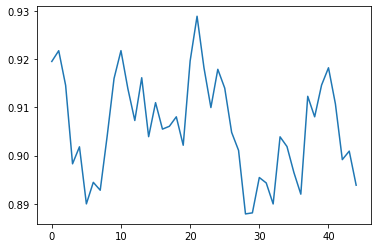

In [226]:
sns.lineplot(data=evaluator.scores_[:, 3])

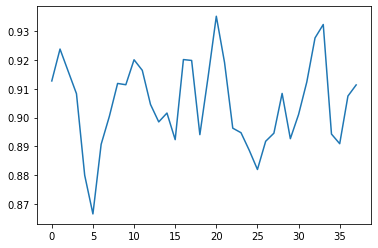

In [145]:
sns.lineplot(data=evaluator.scores_[:, 3])